A continuación vamos a hacer un trabajo similar al hecho para ML con algoritmos de DL, buscando mejorar todo lo posible nuestro score para la predicción de clase sobre la lesividad de un accidente futuro (IL,HL,HG,MT)


In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import pandas as pd
df = pd.read_csv('./trainREADY.csv', sep=';', decimal='.')
df_test = pd.read_csv('./testREADY.csv', sep=';', decimal='.')
print(f'Dimensiones del dataset de training: {df.shape}')
print(f'Dimensiones del dataset de test: {df_test.shape}')


Dimensiones del dataset de training: (144069, 24)
Dimensiones del dataset de test: (35959, 24)


Importamos los datasets y todas las librerías necesarias para nuestro trabajo:

In [3]:
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input
from keras.regularizers import l2
import pandas as pd
import numpy as np
import glob
import os
data1 = df.values
y_train = data1[:,0:1]       # nos quedamos con la 1ª columna, price
X_train = data1[:,1:]      # nos quedamos con el resto
feature_names = df.columns[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

Using TensorFlow backend.


In [4]:
data2 = df_test.values
y_test = data2[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data2[:,1:]      # nos quedamos con el resto
feature_names_test = df_test.columns[1:]

XtestScaled = scaler.transform(X_test)

A continuación vamos a crear algunos modelos de DL con las consignas aprendidas en clase. En el primero, tenemos 5 capas, la primera con un regularizador L2 y una capa de activación "sofmax" al ser clasificación. Cabe recordar que nuestros "outputs" son 4 (IL,HL,HG,MT) de ahí que la última capa tenga 4 neuronas

In [5]:
def create_mlp(data,regress =False):
    model=Sequential()
    model.add(Dense(256, input_dim=data, activation="relu",kernel_regularizer=l2(0.01)))
    model.add(Dense(96, input_dim=data, activation="relu"))
    model.add(Dense(48, input_dim=data, activation="relu"))
    model.add(Dense(12, input_dim=data, activation="relu"))
    model.add(Dense(4, input_dim=data, activation="softmax"))
	# check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
	# return our model
    return model

In [6]:
model = create_mlp(XtrainScaled.shape[1], regress=False)
opt = Adam(lr=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics = ['accuracy'])
print("[INFO] training model...")
history=model.fit(x=XtrainScaled, y=y_train, 
validation_data=(XtestScaled, y_test),
epochs=50, batch_size=8)

[INFO] training model...
Train on 144069 samples, validate on 35959 samples
Epoch 1/100
144069/144069 [==============================] - 138s 956us/sample - loss: 0.6160 - accuracy: 0.7254 - val_loss: 0.6753 - val_accuracy: 0.6822
Epoch 2/100
144069/144069 [==============================] - 133s 923us/sample - loss: 0.5942 - accuracy: 0.7292 - val_loss: 0.7050 - val_accuracy: 0.6773
Epoch 3/100
144069/144069 [==============================] - 139s 966us/sample - loss: 0.5910 - accuracy: 0.7311 - val_loss: 0.6923 - val_accuracy: 0.6791
Epoch 4/100
144069/144069 [==============================] - 142s 985us/sample - loss: 0.5899 - accuracy: 0.7312 - val_loss: 0.6911 - val_accuracy: 0.6814
Epoch 5/100
144069/144069 [==============================] - 139s 965us/sample - loss: 0.5887 - accuracy: 0.7312 - val_loss: 0.6986 - val_accuracy: 0.6882
Epoch 6/100
144069/144069 [==============================] - 137s 950us/sample - loss: 0.5879 - accuracy: 0.7316 - val_loss: 0.7168 - val_accuracy: 0

In [3]:
print ('El mejor resultado obtenido es:Epoch 9/100  loss: 0.5874 - accuracy: 0.7326 - val_loss: 0.6873 - val_accuracy: 0.6901 ')

El mejor resultado obtenido es:Epoch 9/100  loss: 0.5874 - accuracy: 0.7326 - val_loss: 0.6873 - val_accuracy: 0.6901 


In [24]:
preds = model.predict(XtestScaled)
print(preds.mean())

print(XtestScaled.mean())

0.25
0.0007633761982905111


En este segundo modelo introducimos como novedades una capa con Dropout(0.5), otro valor del regularizar L2 y una capa menos para ver si los resultados mejoran:

In [7]:
def create_mlp2(data,regress =False):
    model=Sequential()
    model.add(Dense(128, input_dim=data, activation="relu",kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(48, input_dim=data, activation="relu"))
    model.add(Dense(12, input_dim=data, activation="relu"))
    model.add(Dense(4, input_dim=data, activation="softmax"))
	# check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
	# return our model
    return model

In [8]:
model = create_mlp2(XtrainScaled.shape[1], regress=False)
opt = Adam(lr=0.002)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics = ['accuracy'])
print("[INFO] training model...")
history=model.fit(x=XtrainScaled, y=y_train, 
validation_data=(XtestScaled, y_test),
epochs=50, batch_size=16)

[INFO] training model...
Train on 144069 samples, validate on 35959 samples
Epoch 1/100
144069/144069 [==============================] - 24s 168us/sample - loss: 0.6474 - accuracy: 0.7169 - val_loss: 0.6824 - val_accuracy: 0.6806
Epoch 2/100
144069/144069 [==============================] - 28s 197us/sample - loss: 0.6328 - accuracy: 0.7196 - val_loss: 0.7147 - val_accuracy: 0.6734
Epoch 3/100
144069/144069 [==============================] - 28s 197us/sample - loss: 0.6306 - accuracy: 0.7207 - val_loss: 0.7029 - val_accuracy: 0.6728
Epoch 4/100
144069/144069 [==============================] - 28s 197us/sample - loss: 0.6296 - accuracy: 0.7218 - val_loss: 0.7015 - val_accuracy: 0.6741
Epoch 5/100
144069/144069 [==============================] - 29s 201us/sample - loss: 0.6295 - accuracy: 0.7207 - val_loss: 0.7020 - val_accuracy: 0.6779
Epoch 6/100
144069/144069 [==============================] - 36s 251us/sample - loss: 0.6283 - accuracy: 0.7201 - val_loss: 0.6978 - val_accuracy: 0.6731


In [4]:
print ('El mejor resultado obtenido es: Epoch 13/100 - 50s 350us/sample - loss: 0.6270 - accuracy: 0.7202 - val_loss: 0.6766 - val_accuracy: 0.6864')

El mejor resultado obtenido es: Epoch 13/100 - 50s 350us/sample - loss: 0.6270 - accuracy: 0.7202 - val_loss: 0.6766 - val_accuracy: 0.6864


In [13]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

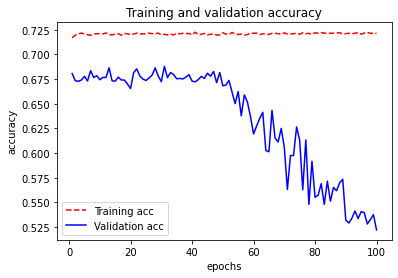

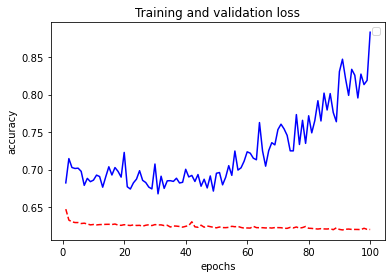

<Figure size 432x288 with 0 Axes>

In [16]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('accuracy')
plt.xlabel('epochs')

plt.legend()
plt.figure()

Vemos como a partir de la época 50 baja la accuracy y aumenta el valor de la función de pérdidas, por lo que los resultados ya no nos serían útiles .

